# AnomalyDetection


Please find 2 ML-based anomaly detection algorithms (other than Elliptic Envelope) and do the following:

    * Explain the theory (working logic) of these models.
    * Given a stock(s) of your choice, run these models, find the anomalies and compare the results.
    
**Note:** You do not need to apply hard math to explain everything behind these models.

In [11]:
#codes here
# work on two algorithms: LOF and 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_blobs
from numpy import quantile, where, random
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [12]:
crash_data = pd.read_csv('crash_data.csv')
crash_data.head()


,Unnamed: 0,RET,date,TICKER,vwretx,BIDLO,ASKHI,PRC,VOL
0,27882462,0.041833,20100104,BAC,0.017045,15.12,15.750,15.69,180845100.0
1,27882463,0.032505,20100105,BAC,0.003362,15.70,16.210,16.20,209521200.0
2,27882464,0.011728,20100106,BAC,0.001769,16.03,16.540,16.39,205257900.0
3,27882465,0.032947,20100107,BAC,0.002821,16.51,17.185,16.93,320868400.0
4,27882466,-0.008860,20100108,BAC,0.004161,16.63,17.100,16.78,220104600.0


In [13]:
crash_data.describe()


,Unnamed: 0,RET,date,vwretx,BIDLO,ASKHI,PRC,VOL
count,6.457900e+04,64579.000000,6.457900e+04,64579.000000,64579.000000,64579.000000,64579.000000,6.457900e+04
mean,1.918824e+07,0.000561,2.014667e+07,0.000415,51.344182,52.215075,51.666965,2.729160e+07
std,1.626793e+07,0.017085,2.852943e+04,0.009237,63.476220,64.644734,64.176051,3.472951e+07
min,2.772540e+05,-0.205436,2.010010e+07,-0.068801,0.610000,0.660000,-18.895000,0.000000e+00
25%,6.854786e+06,-0.006901,2.012083e+07,-0.003583,18.200000,18.560000,18.380000,9.678574e+06
50%,1.357504e+07,0.000459,2.015022e+07,0.000644,36.230000,36.820000,36.510000,1.778311e+07
75%,2.788268e+07,0.008105,2.017081e+07,0.005059,62.120000,62.980000,62.570000,3.255229e+07
max,6.372877e+07,0.296077,2.019123e+07,0.051197,699.570010,705.070010,702.099980,8.596433e+08


In [14]:
crash_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64579 entries, 0 to 64578
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  64579 non-null  int64  
 1   RET         64579 non-null  float64
 2   date        64579 non-null  int64  
 3   TICKER      64579 non-null  object 
 4   vwretx      64579 non-null  float64
 5   BIDLO       64579 non-null  float64
 6   ASKHI       64579 non-null  float64
 7   PRC         64579 non-null  float64
 8   VOL         64579 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 4.4+ MB


### Converting date to datetime format

In [15]:
crash_data.date = pd.to_datetime(crash_data.date, format='%Y%m%d')
crash_data = crash_data.set_index('date')

In [16]:
crash_data.describe()

,Unnamed: 0,RET,vwretx,BIDLO,ASKHI,PRC,VOL
count,6.457900e+04,64579.000000,64579.000000,64579.000000,64579.000000,64579.000000,6.457900e+04
mean,1.918824e+07,0.000561,0.000415,51.344182,52.215075,51.666965,2.729160e+07
std,1.626793e+07,0.017085,0.009237,63.476220,64.644734,64.176051,3.472951e+07
min,2.772540e+05,-0.205436,-0.068801,0.610000,0.660000,-18.895000,0.000000e+00
25%,6.854786e+06,-0.006901,-0.003583,18.200000,18.560000,18.380000,9.678574e+06
50%,1.357504e+07,0.000459,0.000644,36.230000,36.820000,36.510000,1.778311e+07
75%,2.788268e+07,0.008105,0.005059,62.120000,62.980000,62.570000,3.255229e+07
max,6.372877e+07,0.296077,0.051197,699.570010,705.070010,702.099980,8.596433e+08


In [17]:
crash_data

,Unnamed: 0,RET,TICKER,vwretx,BIDLO,ASKHI,PRC,VOL
date,,,,,,,,
2010-01-04,27882462,0.041833,BAC,0.017045,15.12000,15.75000,15.69000,180845100.0
2010-01-05,27882463,0.032505,BAC,0.003362,15.70000,16.21000,16.20000,209521200.0
2010-01-06,27882464,0.011728,BAC,0.001769,16.03000,16.54000,16.39000,205257900.0
2010-01-07,27882465,0.032947,BAC,0.002821,16.51000,17.18500,16.93000,320868400.0
2010-01-08,27882466,-0.008860,BAC,0.004161,16.63000,17.10000,16.78000,220104600.0
...,...,...,...,...,...,...,...,...
2019-12-24,7045394,-0.005141,FB,0.000268,205.00000,206.78999,205.12000,6035490.0
2019-12-26,7045395,0.013017,FB,0.004530,205.31000,207.82001,207.78999,9360333.0
2019-12-27,7045396,0.001492,FB,-0.000714,206.58749,208.92999,208.10001,10278335.0


We have to convert the daily data into the weekly data and groupby the tickers

In [18]:
crash_data_weekly = crash_data.groupby('TICKER').resample('W').\
              agg({'RET':'mean', 'vwretx':'mean', 'VOL':'mean',
                   'BIDLO':'mean', 'ASKHI':'mean', 'PRC':'mean'})

In [19]:
crash_data_weekly = crash_data_weekly.reset_index()

In [23]:
crash_data_weekly.dropna(inplace=True)
stocks_unique = crash_data_weekly.TICKER.unique()

In [25]:
stocks_unique #Listing gall the distinct stock companies

array(['AAPL', 'BAC', 'BBDO', 'CMCSA', 'CSCO', 'DWDP', 'F', 'FB', 'GE',
       'INTC', 'JNJ', 'JPM', 'KO', 'MOT', 'MRK', 'MSFT', 'ORCL', 'OUBS',
       'PFE', 'PG', 'S', 'SIRI', 'T', 'TSU', 'UBS', 'VZ', 'WFC', 'WMT',
       'XOM'], dtype=object)

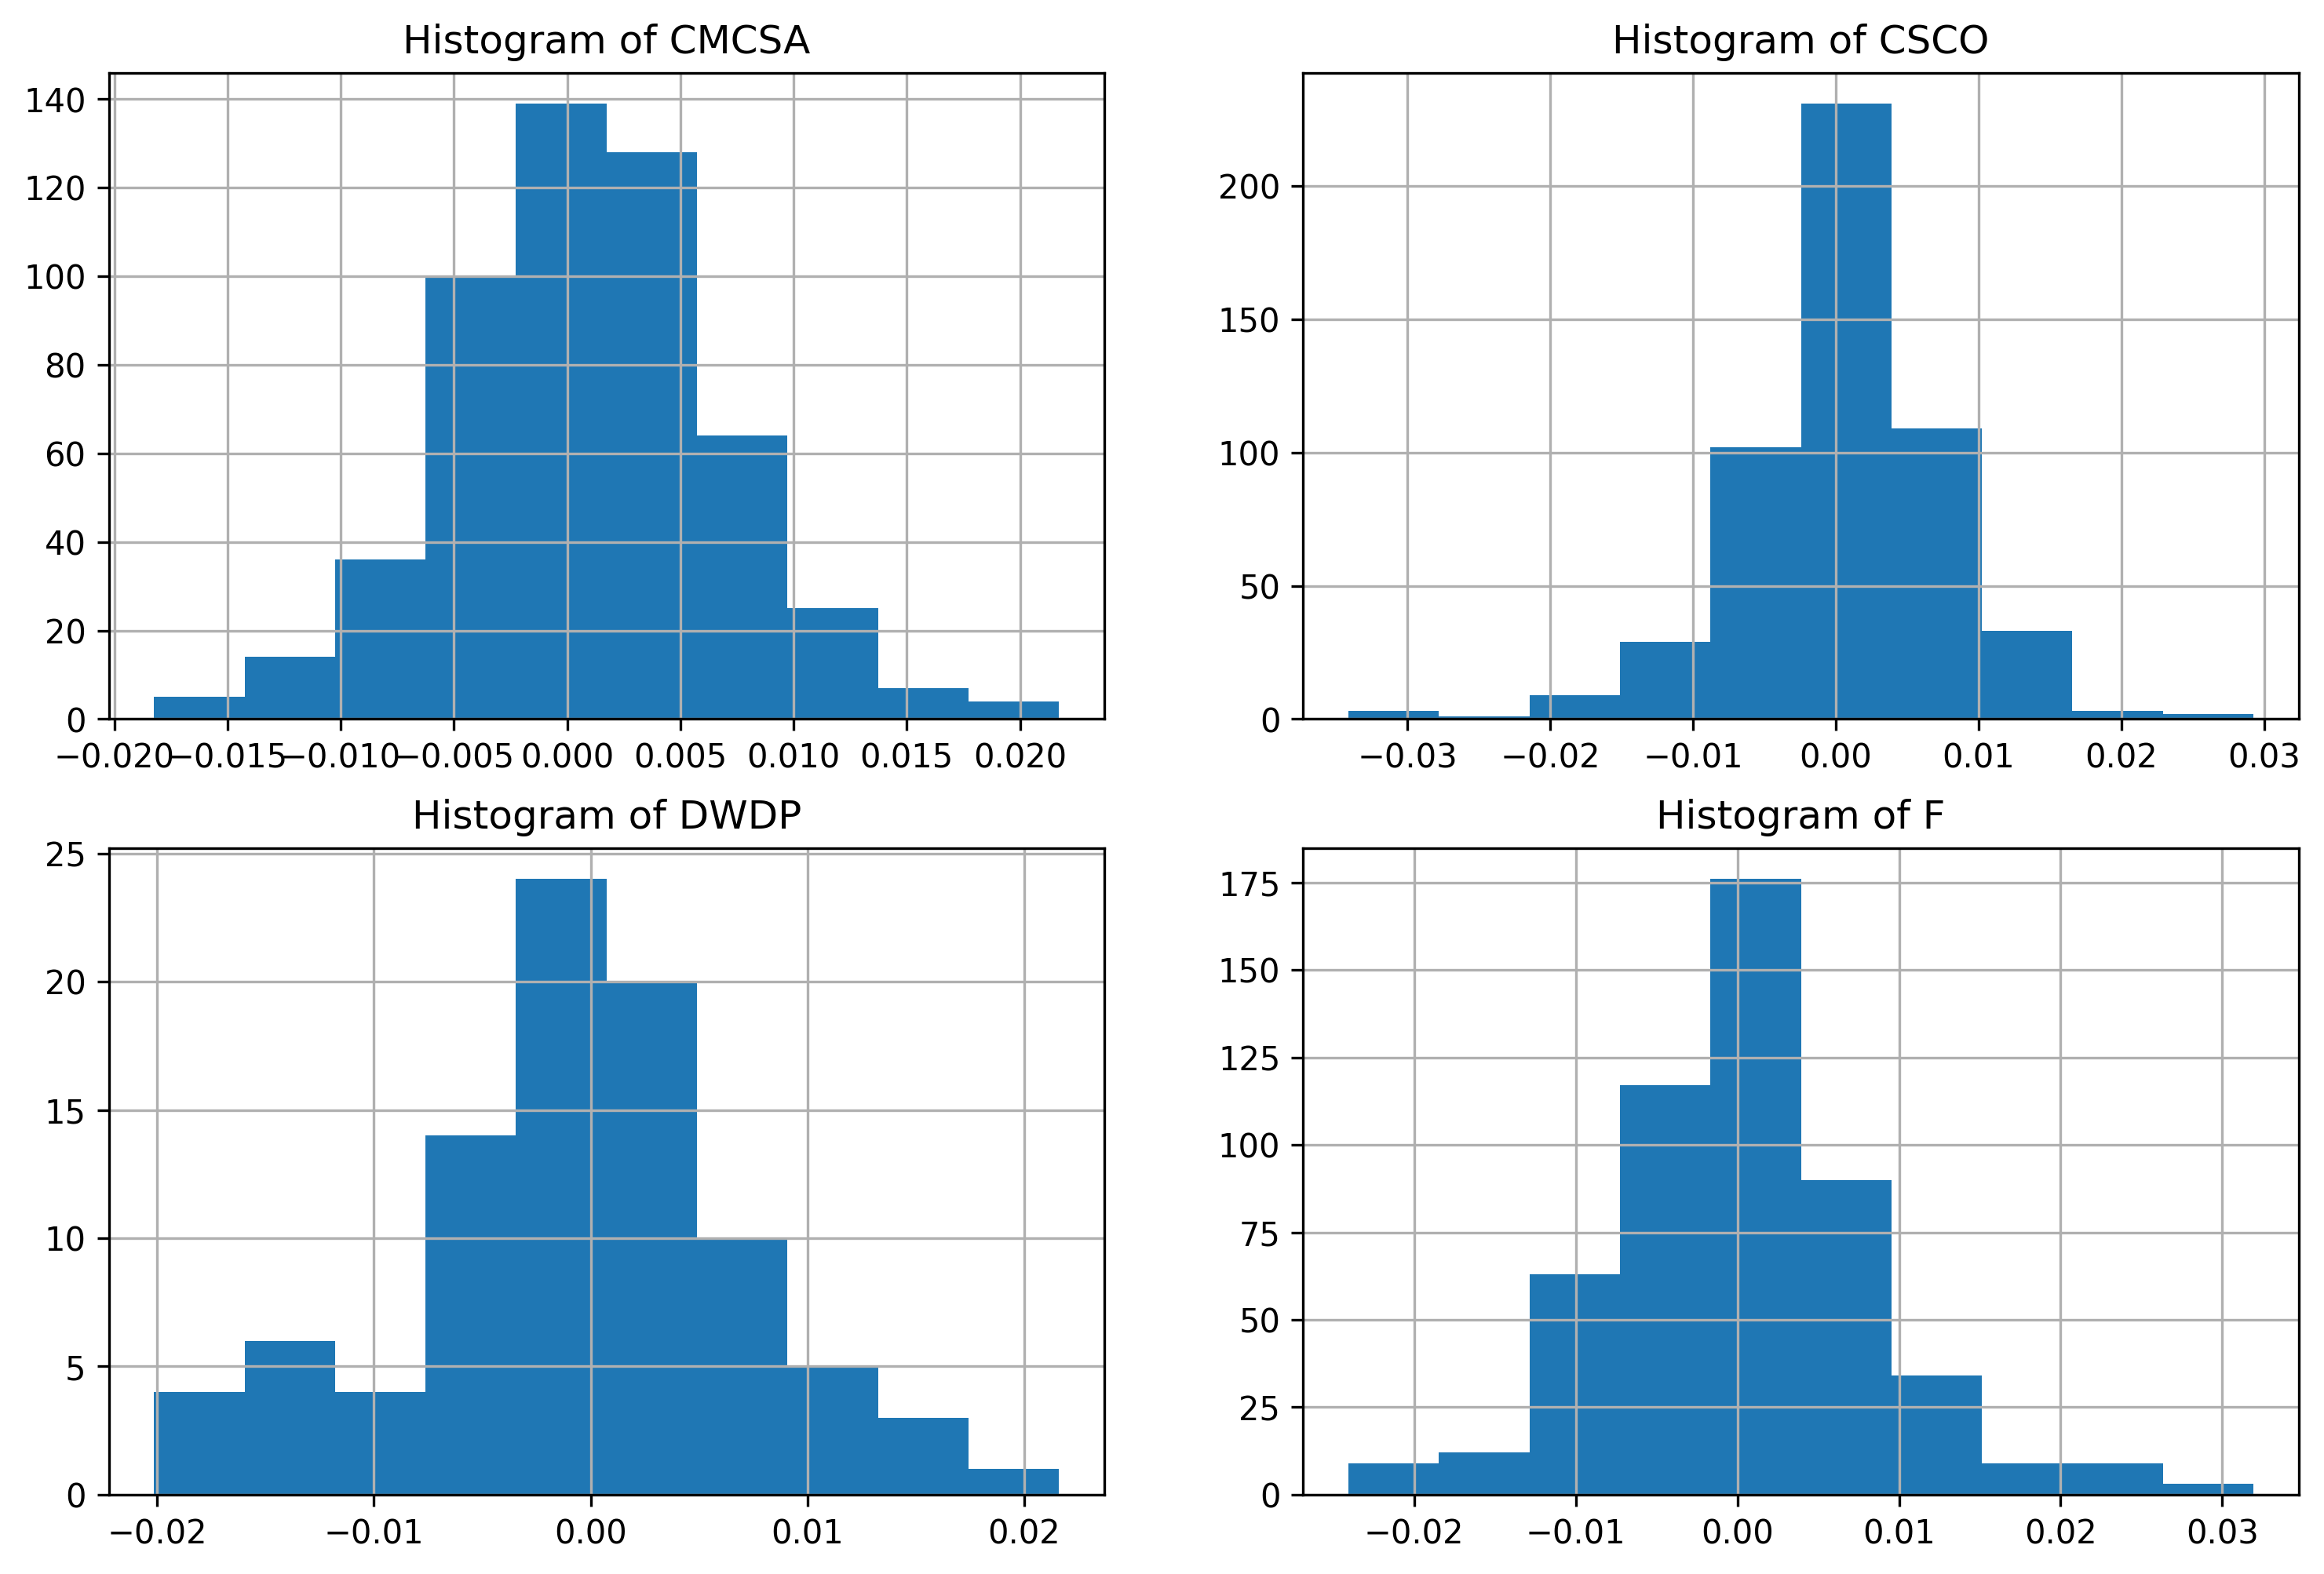

In [27]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.figure(figsize=(12, 8))
k = 1

for i in stocks_unique[3:7]:
    plt.subplot(2, 2, k)
    plt.hist(crash_data_weekly[crash_data_weekly.TICKER == i]['RET'])
    plt.title('Histogram of '+i)
    plt.grid()
    k+=1
plt.show()

### For Firm specific return we have to extract the residuals from the CAPM

In [31]:
X = crash_data_weekly.loc[crash_data_weekly['TICKER'] == i]['vwretx'].values
X

array([ 5.83160000e-03, -2.08000000e-03, -9.47950000e-03, -3.73800000e-03,
       -1.46340000e-03,  2.97040000e-03,  7.69975000e-03, -9.91000000e-04,
        7.06140000e-03,  2.30060000e-03,  9.24400000e-04,  9.84600000e-04,
        3.16275000e-03,  3.09360000e-03, -2.67600000e-04,  4.48580000e-03,
       -5.06980000e-03, -1.41056000e-02,  5.87300000e-03, -9.37940000e-03,
        1.52680000e-03, -5.82050000e-03,  5.29780000e-03,  5.00540000e-03,
       -6.77940000e-03, -1.08320000e-02,  1.30712500e-02, -2.61320000e-03,
        7.47920000e-03,  4.44000000e-05,  3.26600000e-03, -8.10960000e-03,
       -5.60200000e-04, -6.54000000e-04,  7.42080000e-03,  5.70000000e-04,
        3.10380000e-03,  3.97760000e-03,  5.47600000e-04,  3.34100000e-03,
        1.97260000e-03,  6.10400000e-04,  4.91400000e-04,  7.23340000e-03,
       -4.32060000e-03,  4.38600000e-04, -1.47800000e-03,  5.95140000e-03,
        2.26780000e-03,  4.12400000e-04,  2.60325000e-03,  5.49200000e-04,
        1.56340000e-03,  

In [33]:
import statsmodels.api as sm
residuals = []

for i in stocks_unique:
    Y = crash_data_weekly.loc[crash_data_weekly['TICKER'] == i]['RET'].values
    X = crash_data_weekly.loc[crash_data_weekly['TICKER'] == i]['vwretx'].values
    X = sm.add_constant(X)
    ols = sm.OLS(Y[2:-2], X[2:-2] + X[1:-3] + X[0:-4] + \
                 X[3:-1] + X[4:]).fit()
    residuals.append(ols.resid) #this gives us the residuals

In [ ]:
residuals = list(map(lambda x: np.log(1 + x), residuals))

In [34]:
crash_data_sliced = pd.DataFrame([])
for i in stocks_unique:
    crash_data_sliced = crash_data_sliced.append(crash_data_weekly.loc[crash_data_weekly.TICKER == i]
                               [2:-2])
crash_data_sliced.head()

,TICKER,date,RET,vwretx,VOL,BIDLO,ASKHI,PRC
2,AAPL,2010-01-24,-0.009510,-0.009479,25930885.00,205.277505,212.888450,208.146752
3,AAPL,2010-01-31,-0.005426,-0.003738,52020594.00,198.250202,207.338002,201.650398
4,AAPL,2010-02-07,0.003722,-0.001463,26953208.40,192.304004,197.378002,195.466002
5,AAPL,2010-02-14,0.005031,0.002970,19731018.60,194.513998,198.674002,196.895200
6,AAPL,2010-02-21,0.001640,0.007700,16618997.25,201.102500,203.772500,202.636995


In [35]:
len(crash_data_sliced)

13286

## Anomaly Detection



### We will be using residuals ans using that we can find the anomalies in the data which can give us foundation that a particular stock is crashing or leading

### One-Class SVM Outlier Detection

In [43]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)

In [44]:
svm_predictions = {}

for i, j in zip(range(len(stocks_unique)), stocks_unique):
    svm.fit(np.array(residuals[i]).reshape(-1, 1))
    svm_predictions[j] = svm.predict(np.array(residuals[i])
                                         .reshape(-1, 1))

In [45]:
transform = []

for i in stocks_unique:
    for j in range(len(svm_predictions[i])):
        transform.append(np.where(svm_predictions[i][j] == 1, 0, -1))

In [46]:
crash_data_sliced = crash_data_sliced.reset_index()
crash_data_sliced['residuals'] = np.concatenate(residuals)
crash_data_sliced['neg_outliers'] = np.where((np.array(transform)) == -1, 1, 0)
crash_data_sliced.loc[(crash_data_sliced.neg_outliers == 1) &
                      (crash_data_sliced.residuals > 0),
                      'neg_outliers'] = 0

In [47]:
crash_data_sliced['neg_outliers'].value_counts()

0    11564
1     1722
Name: neg_outliers, dtype: int64

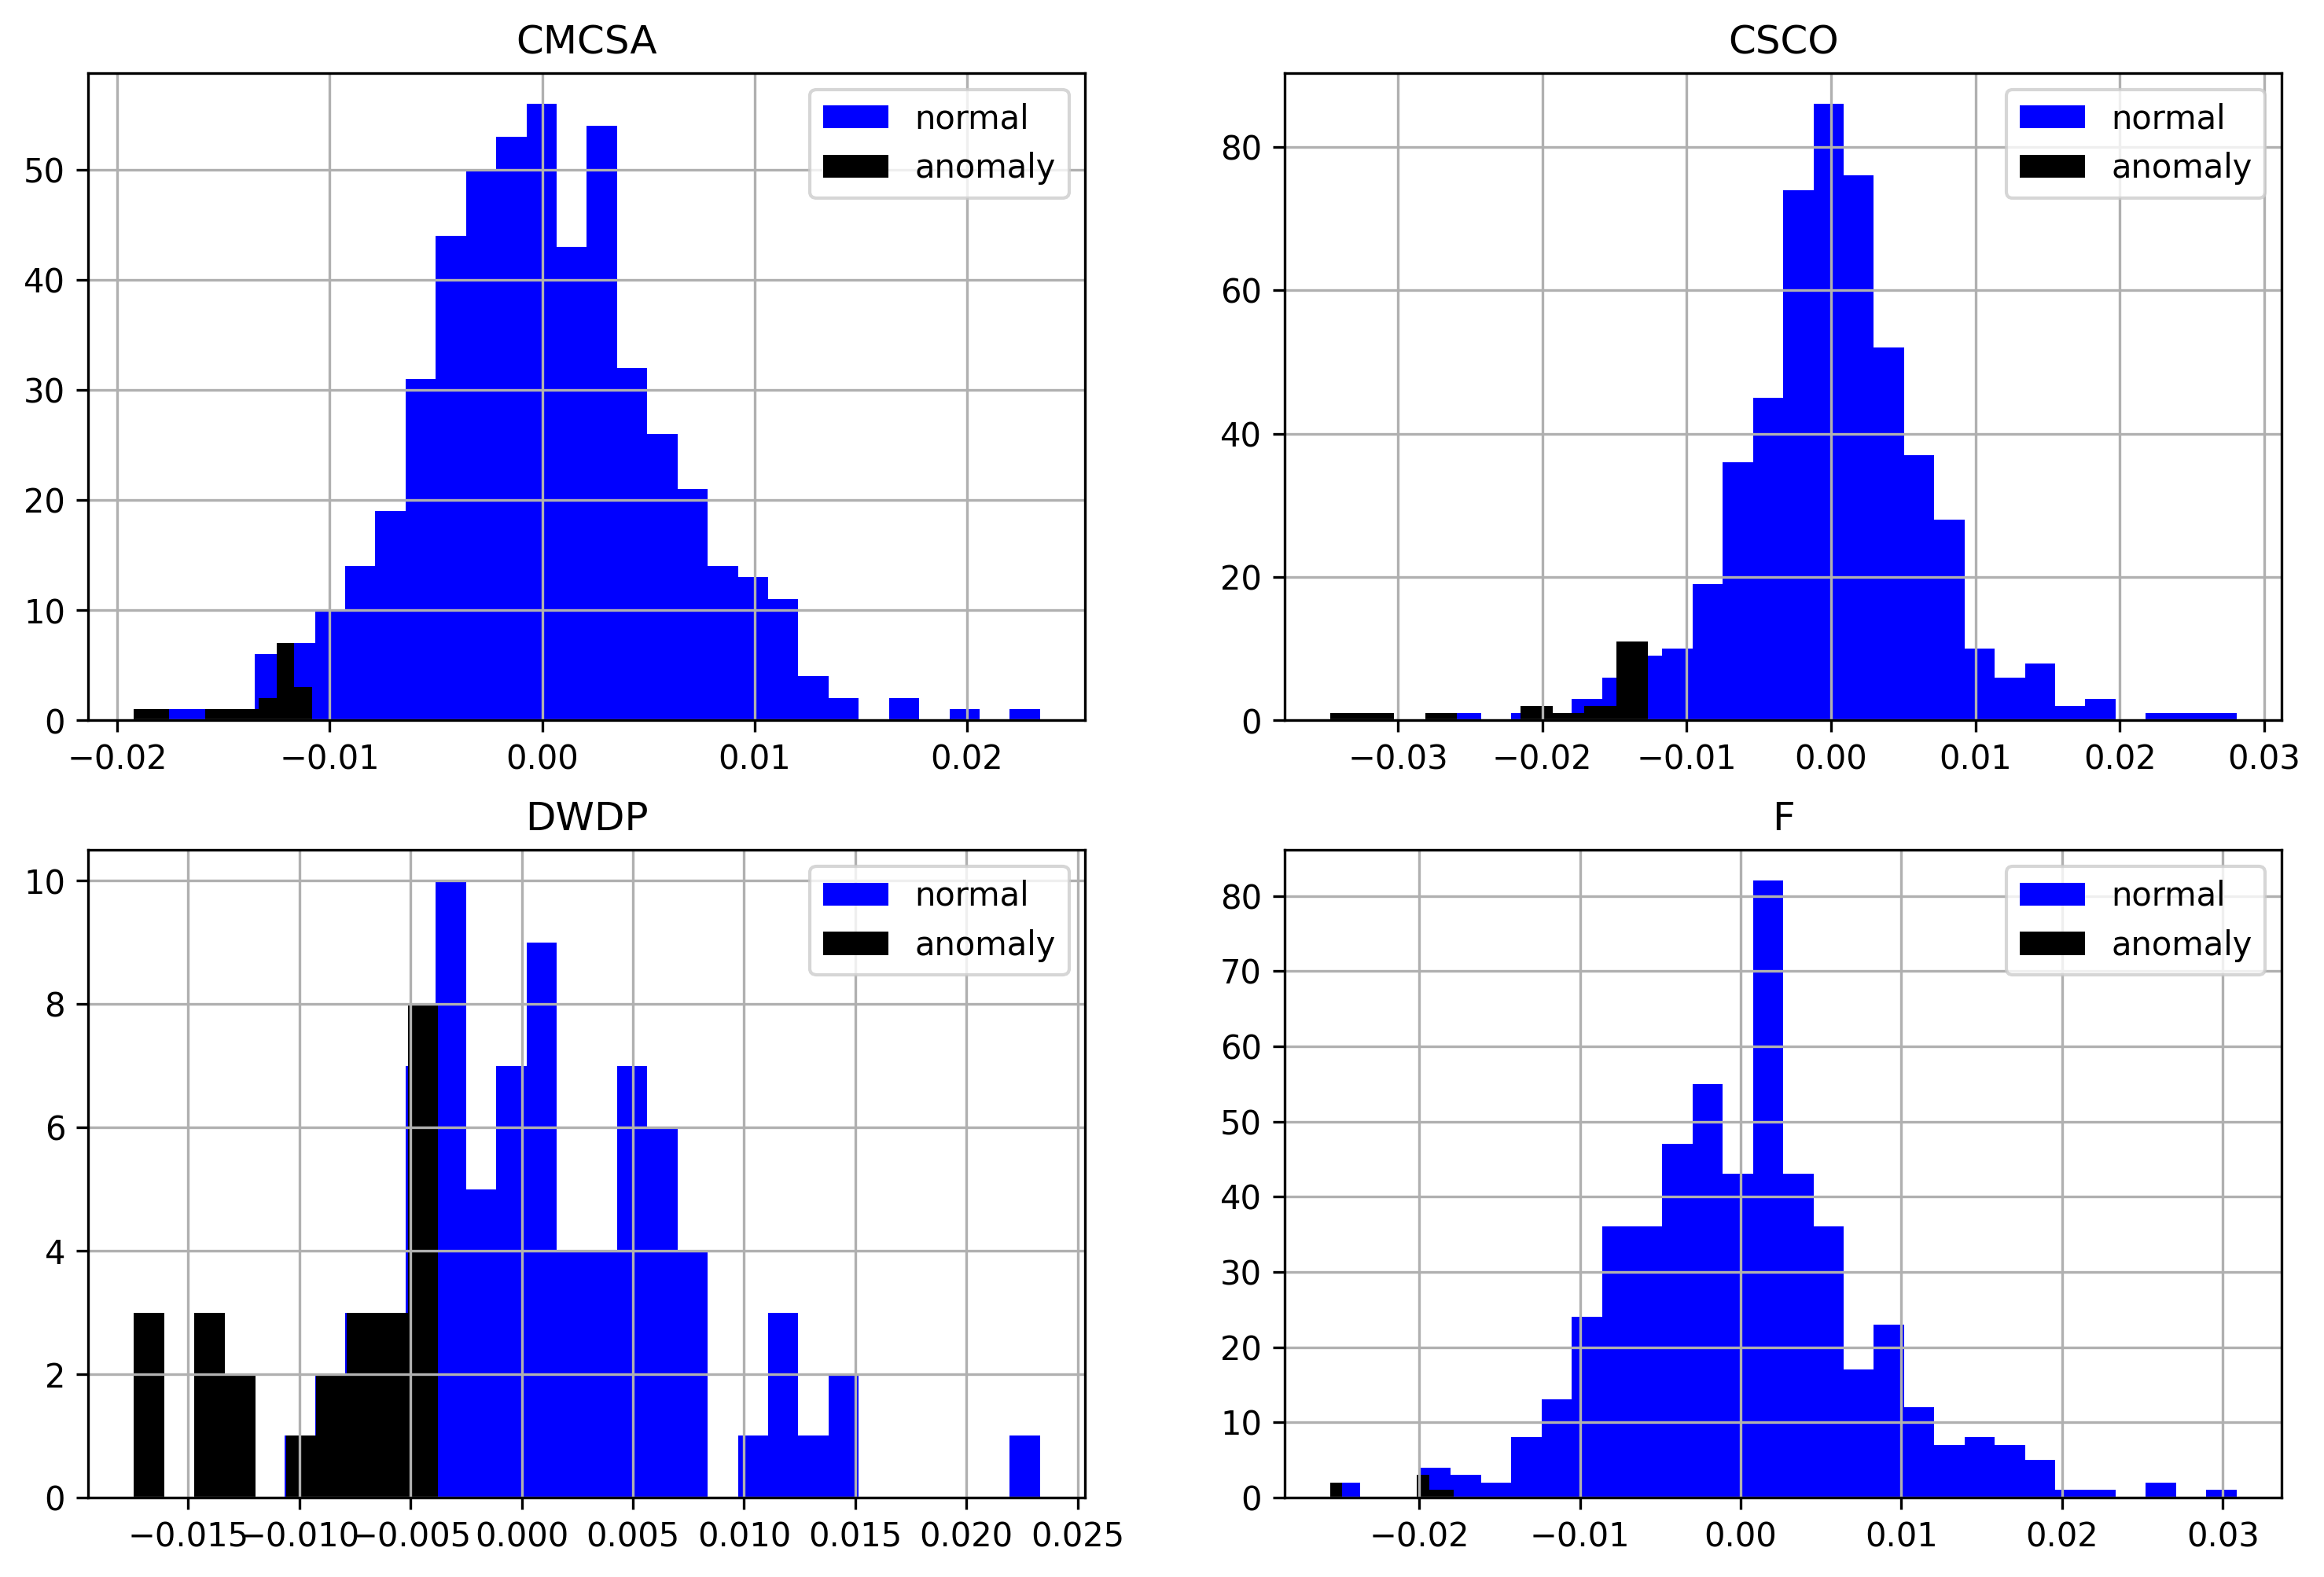

In [49]:
plt.figure(figsize=(12, 8)) 
k=1

for i in stocks_unique[3:7]:
    plt.subplot(2, 2, k)
    crash_data_sliced['residuals'][crash_data_sliced.TICKER == i]\
    .hist(label='normal', bins=30, color='blue')
    outliers = crash_data_sliced['residuals'][(crash_data_sliced.TICKER == i) &
    (crash_data_sliced.neg_outliers > 0)]
    outliers.hist(color='black', label='anomaly') 
    plt.title(i)
    plt.legend()
    k+=1

### Isolation forest 

In [50]:
iforest = IsolationForest(n_estimators=60, contamination=.02)
iforest_predictions = {}

for i, j in zip(range(len(stocks_unique)), stocks_unique):
    iforest.fit(np.array(residuals[i]).reshape(-1, 1))
    iforest_predictions[j] = iforest.predict(np.array(residuals[i])
                                         .reshape(-1, 1))
    
transform = []

for i in stocks_unique:
    for j in range(len(iforest_predictions[i])):
        transform.append(np.where(iforest_predictions[i][j] == 1, 0, -1))

In [51]:
crash_data_sliced['residuals'] = np.concatenate(residuals)
crash_data_sliced['neg_outliers'] = np.where((np.array(transform)) == -1, 1, 0)
crash_data_sliced.loc[(crash_data_sliced.neg_outliers == 1) &
                      (crash_data_sliced.residuals > 0),
                      'neg_outliers'] = 0

In [52]:
crash_data_sliced['neg_outliers'].value_counts()

0    13148
1      138
Name: neg_outliers, dtype: int64

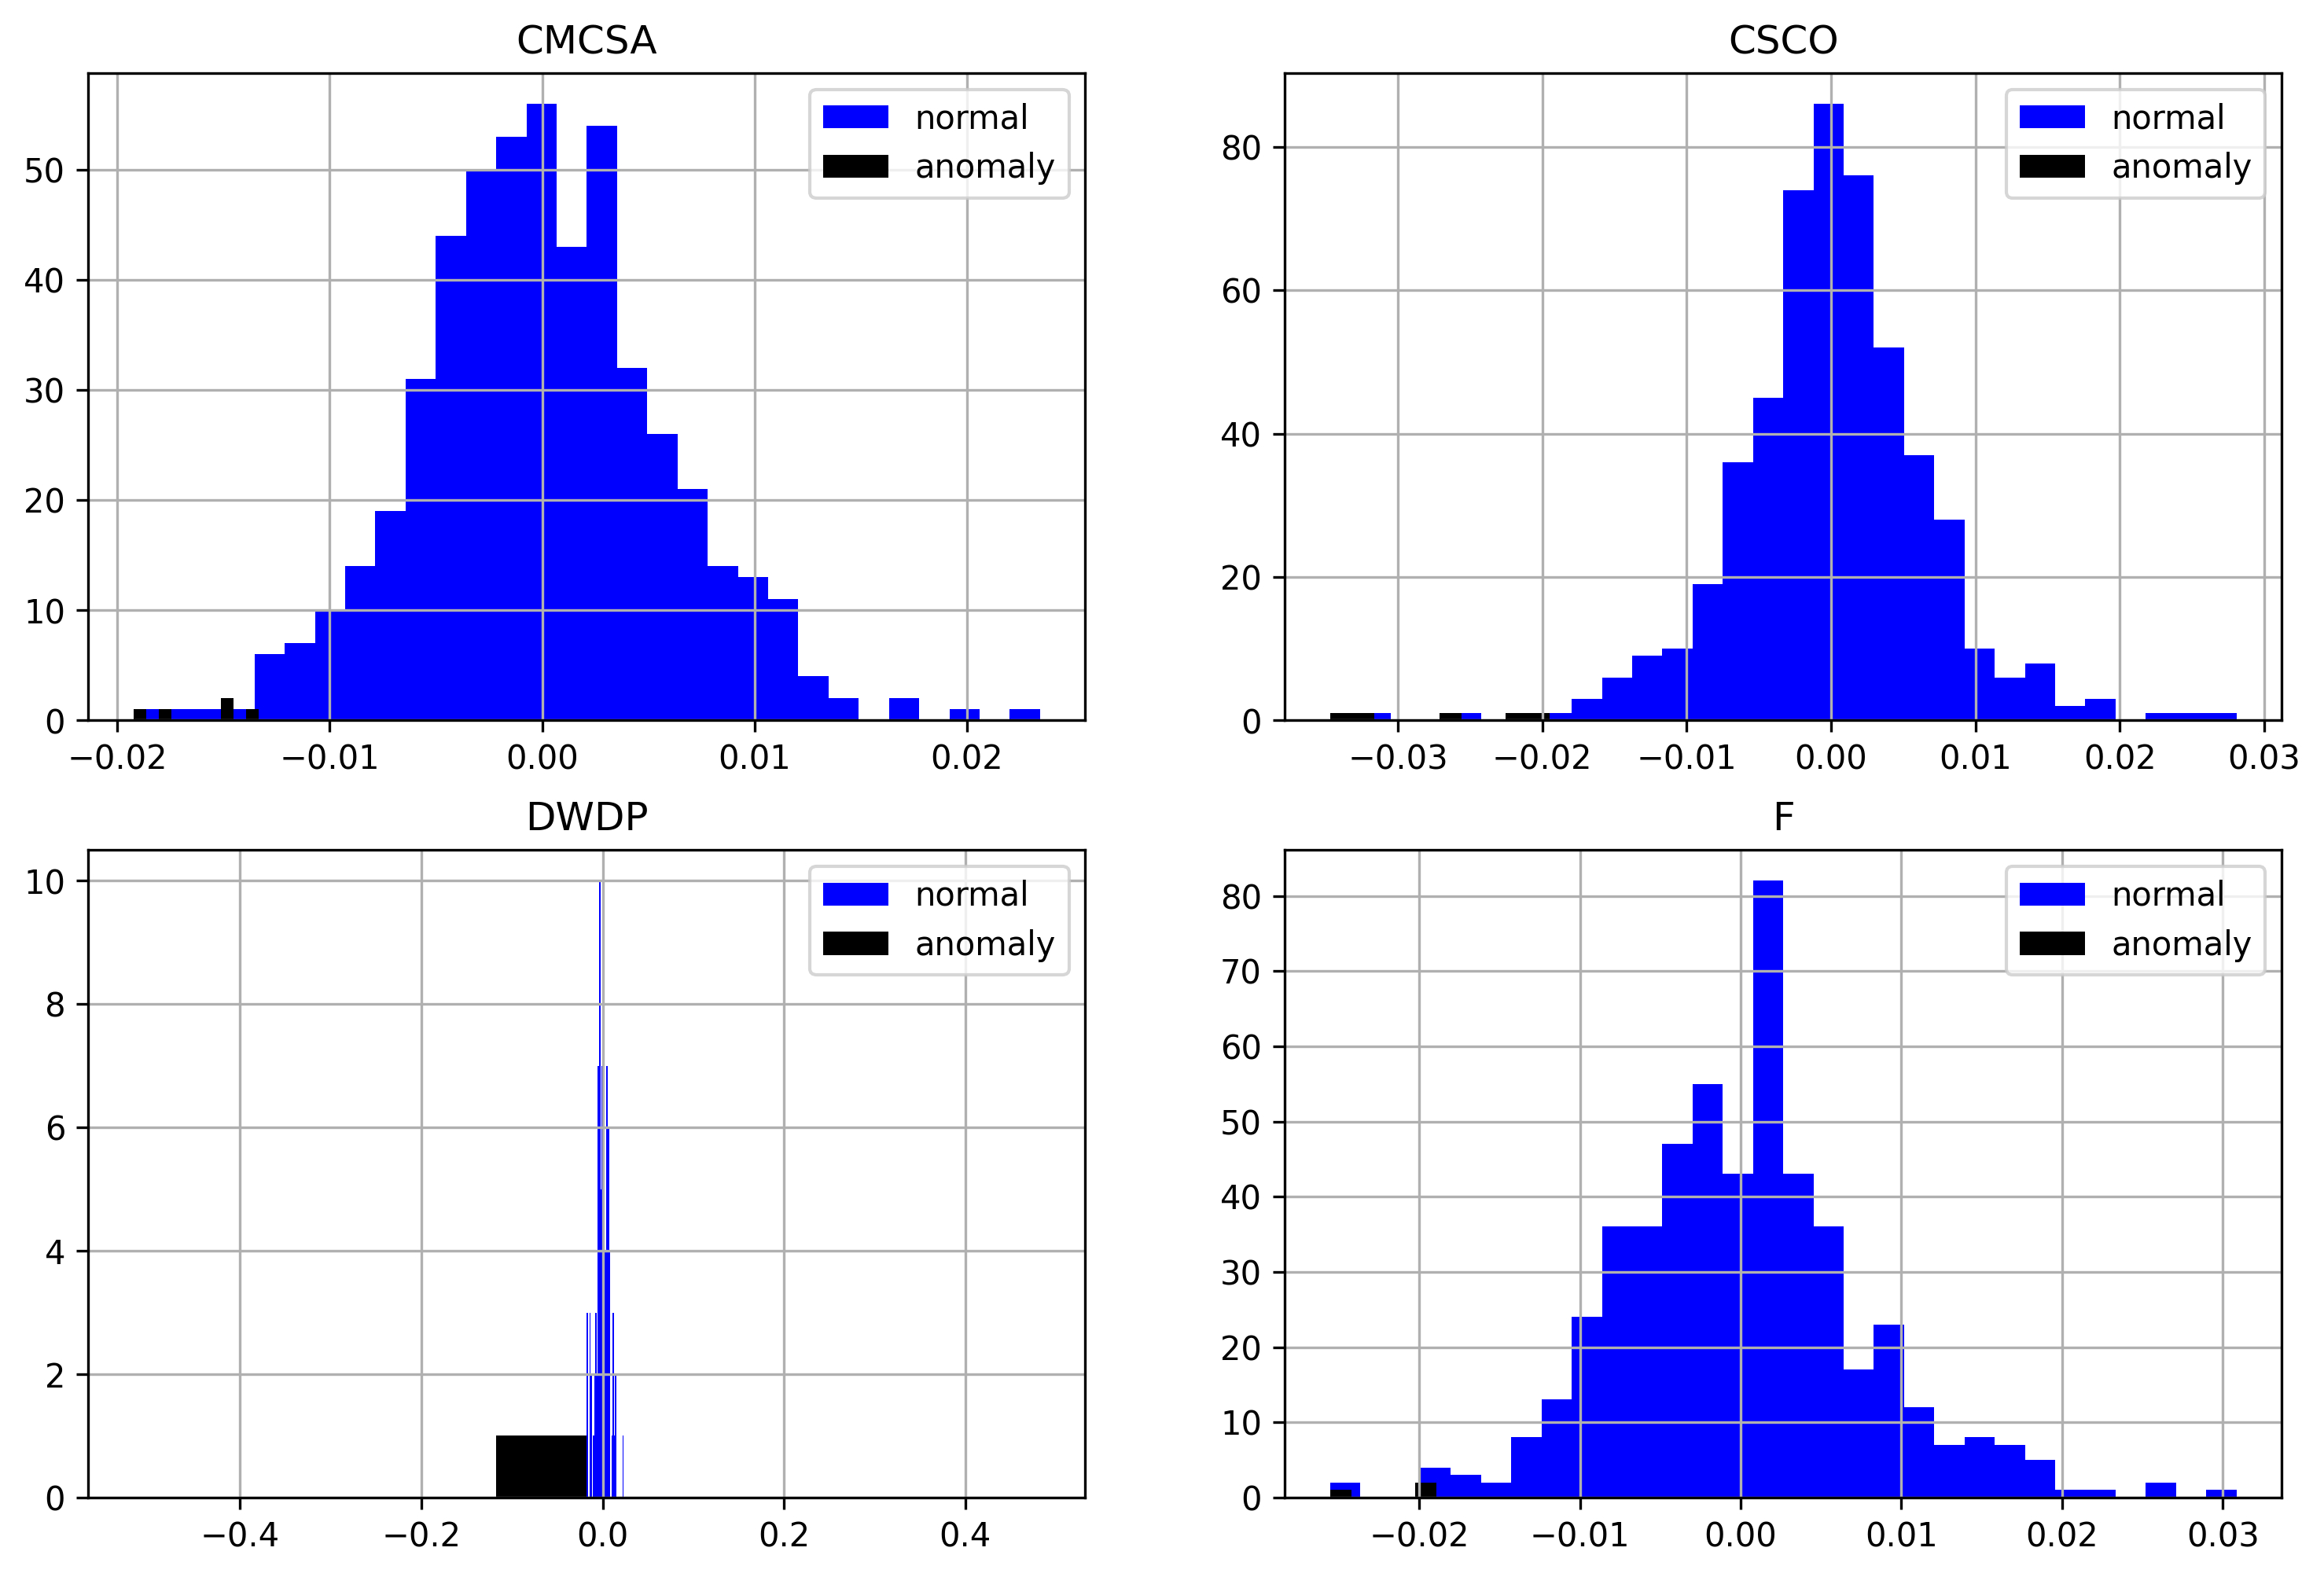

In [54]:
plt.figure(figsize=(12, 8)) 
k=1

for i in stocks_unique[3:7]:
    plt.subplot(2, 2, k)
    crash_data_sliced['residuals'][crash_data_sliced.TICKER == i]\
    .hist(label='normal', bins=30, color='blue')
    outliers = crash_data_sliced['residuals'][(crash_data_sliced.TICKER == i) &
    (crash_data_sliced.neg_outliers > 0)]
    outliers.hist(color='black', label='anomaly') 
    plt.title(i)
    plt.legend()
    k+=1